In [1]:
import pandas as pd
import ipywidgets as w
from IPython.display import display, IFrame
import pyspark
from pyspark.sql import SQLContext, functions, types
from pyspark.sql import Row
import matplotlib.pyplot as plt
from hotel_rec import *
import json
import constants as const
%matplotlib inline

In [4]:
sc=pyspark.SparkContext(appName=const.HOTEL_REC_APP_NAME)
spark = SQLContext(sc)

C:\Users\thapq\AppData\Roaming\Python\Python311\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## User details and Preferences

In [5]:
name = w.Text(description="Tên người dùng")
place = w.Text(description="Tỉnh/Thành phố")
v1 = w.VBox([name,place])

start = w.DatePicker(description='Ngày bắt đầu', disabled=False)
end = w.DatePicker(description='Ngày kết thúc', disabled=False)
v2 = w.VBox([start,end])

out = w.HBox([v1,v2])
display(out)

In [6]:
hotel_df = spark.read.json(const.DIR_DATA_HOTEL)
hotel_amenity_df = spark.read.json(const.DIR_DATA_HOTEL_AMENITIES)

hotel_df.createOrReplaceTempView('hotel_df')
hotel_amenity_df.createOrReplaceTempView('hotel_amenity_df')

In [7]:
place.value
# ở hệ thống thì cứ thay bằng Hà Nội, không sao cả

'Hà Nội'

In [8]:
# Tìm ra top 15 độ tiện nghi của khách sạn
temp_amenity_df  = spark.sql("SELECT amenities, COUNT(amenities) AS tot_count FROM hotel_amenity_df GROUP BY amenities ORDER BY tot_count DESC")
top_amenities = [x[0] for x in temp_amenity_df.head(21) if x[0] != '']

# Lựa chọn độ tiện nghi của du khách (chọn 5)
amenities_pref = []
def on_button_clicked(b):
    if b.description in amenities_pref:
        return
    
    print(b.description)
    amenities_pref.append(b.description)
    if(len(amenities_pref) < 5):
        print("Select {x} more!\n".format(x=5-len(amenities_pref)))
        
but_layout = w.Layout(width='100%', height='100px')
but_items = [w.Button(description=c, layout=but_layout) for c in top_amenities]
on_clk = [item.on_click(on_button_clicked) for item in but_items]
r1 = w.VBox([i for i in but_items[:5]])
r2 = w.VBox([i for i in but_items[5:10]])
r3 = w.VBox([i for i in but_items[10:]])
buttons = w.HBox([r1,r2,r3])

print("Select atleast 5 amenities:")
display(buttons)

Select atleast 5 amenities:


 Refrigerator in room
Select 4 more!

 Family Rooms
Select 3 more!

 Public Wifi
Select 2 more!

 Pets Allowed  Dog  Pet Friendly 
Select 1 more!

 Breakfast included


In [9]:
temp = spark.sql('select count(*) from hotel_df')
temp.show()

+--------+
|count(1)|
+--------+
|      47|
+--------+



## Model training and evaluation

DataFrame[user_id: bigint, att_id: bigint, user_rating: bigint, prediction: float]
best rank :  12
best RMSE:3.2559769498805804


<BarContainer object of 3 artists>

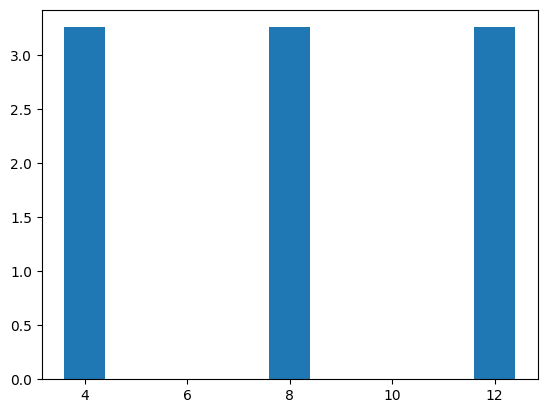

In [10]:
# write list to JSON file
temp_json_amenities = []
for amenity in amenities_pref:
    temp_json_amenities.append({'amenities_pref': amenity})

with open('temp_amenities_pref.json', 'w') as f:
    json.dump(temp_json_amenities, f)

amenities_pref_df = spark.read.json('temp_amenities_pref.json')

usr_rating = amenities_rating(spark, amenities_pref_df, hotel_amenity_df)
rank, error, errors, usrid_s2, model = model_train(spark, usr_rating)

print("best rank : ",rank)
print("best RMSE:" +str(error))
plt.bar([4,8,12], height=errors)

## Getting Recommendation

In [11]:
# check if model is None
model

ALSModel: uid=ALS_916dbd7ad62a, rank=12

In [12]:
user = usrid_s2.select("user_id").distinct()
recomm = model.recommendForUserSubset(user,50)
recomm.createOrReplaceTempView('recomm')

recomm.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    111|[{1999, 4.995845}...|
+-------+--------------------+



In [14]:
u_tempdf = get_hotel_recc(spark, usrid_s2, model)
# hotel_df = hotel_df.join(u_tempdf, "id").withColumn("address",functions.lower(functions.col("address")))
u_tempdf.createOrReplaceTempView('u_temp_df')
a = spark.sql('select distinct * from u_temp_df')
hotel_df = hotel_df.join(a, "id")
# user_location = place.value.lower()
hotel_sugg = hotel_df.where(hotel_df.city == place.value)
hotel_sugg.createOrReplaceTempView('hotel_df_sugg_view')
sugg_view = spark.sql('select distinct * from hotel_df_sugg_view')
# hotel_sugg = hotel_df.where(hotel_df.address.contains(user_location))
recc = sugg_view.dropna().toPandas()

# hotel_df = spark.read.json(const.DIR_DATA_HOTEL)
# hotel_df.createOrReplaceTempView('hotel_df')

# hotel_temp_df = hotel_df.join(u_tempdf, "id")


# TODO:
# u_tempdf.createOrReplaceTempView('u_tempdf')
# temp = spark.sql('select * from u_tempdf limit 30')
# temp.show()

In [28]:
# temp = hotel_df.dropna().toPandas()
# temp

# hotel_df.createOrReplaceTempView('hotel_df_view')

# a = spark.sql('select distinct * from hotel_df_view')

# a.show()

+------------------------------------------------------------------------------+
|count(DISTINCT id, amenities, city, hotel_name, hotel_rating, location, price)|
+------------------------------------------------------------------------------+
|                                                                            42|
+------------------------------------------------------------------------------+



In [15]:
# after_hotel_df = spark.read.json(const.DIR_DATA_HOTEL)
# after_hotel_pd_df = after_hotel_df.dropna().toPandas()
# after_hotel_pd_df

recc

,id,amenities,city,hotel_name,hotel_rating,location,price
0,3382,"[lodging, point_of_interest, establishment]",Hà Nội,Bodega hotel,3.6,"(21.0294717, 105.8457518)",590000
1,1471,"[lodging, point_of_interest, establishment]",Hà Nội,HOSTEL TURBO,3.6,"(21.0287617, 105.8389443)",650000
2,4278,"[lodging, point_of_interest, establishment]",Hà Nội,A25 Hotel - 12 Ngô Sĩ Liên,4.2,"(21.0278672, 105.8389605)",500000
3,1312,"[lodging, point_of_interest, establishment]",Hà Nội,Hanoi Larosa Hotel,4.0,"(21.0279406, 105.8403566)",740000
4,2522,"[lodging, point_of_interest, establishment]",Hà Nội,Canary Hanoi Hotel,3.7,"(21.0195643, 105.8419895)",740000
5,4010,"[lodging, point_of_interest, establishment]",Hà Nội,Somerset Grand Hanoi,4.4,"(21.0258293, 105.846344)",2000000
6,3387,"[lodging, point_of_interest, establishment]",Hà Nội,Rustic House,3.3,"(21.0249915, 105.8217855)",890000
7,946,"[lodging, point_of_interest, establishment]",Hà Nội,ARL Kim Mã No.1,4.0,"(21.03144619999999, 105.8245614)",750000
8,946,"[lodging, point_of_interest, establishment]",Hà Nội,Sunny Hotel,3.5,"(21.0258333, 105.8283333)",530000
9,1999,"[lodging, point_of_interest, establishment]",Hà Nội,Green Hostel,4.4,"(21.0382601, 105.8293268)",900000


In [16]:
%%capture
final = dict()
# final['address'] = recc[:5]['address'].values.tolist()
final['amenities'] = recc[:5]['amenities'].values.T.tolist()
# final['experience'] = recc[:5]['hotel_experience'].values.tolist()
final['name'] = recc[:5]['hotel_name'].values.tolist()
final['rating'] = recc[:5]['hotel_rating'].values.tolist()
final['location'] = [i[1:-1] for i in recc[:5]['location'].values.tolist()]
final['price'] = recc[:5]['price'].values.tolist()
final['image'] = [get_image(i) for i in recc[:5]['hotel_name'].values.tolist()]



In [15]:
final

{'amenities': [['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment']],
 'name': ['Green Hostel',
  'Saigon Sun Hotel 1',
  'Thanglong GTC Hanoi Hotel',
  'Green Hostel',
  'Saigon Sun Hotel 1'],
 'rating': [4.4, 3.5, 3.7, 4.4, 3.5],
 'location': ['21.0382601, 105.8293268',
  '21.0195574, 105.8254407',
  '21.0264139, 105.8368171',
  '21.0382601, 105.8293268',
  '21.0195574, 105.8254407'],
 'price': [0, 600000, 0, 0, 600000],
 'image': ['../assets/images/noimage.jpg', None, None, None, None]}

## Final Output

In [17]:
days = (end.value - start.value).days
tab_recc = get_hotel_output(days, final)
display(tab_recc)